In [1]:
%reload_ext autoreload
%autoreload 2

# %matplotlib widget

%matplotlib qt

# %gui qt

import time
import random
from copy import copy
from tqdm import tqdm
from pathlib import Path
import numpy as np
import numba as nb
import scipy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
pd.options.display.width = 1000

from vrAnalysis import session
from vrAnalysis import registration
from vrAnalysis import functions
from vrAnalysis import analysis
from vrAnalysis import helpers
from vrAnalysis import fileManagement as fm
from vrAnalysis import database
from vrAnalysis import tracking

from vrAnalysis.uiDatabase import addEntryGUI
from vrAnalysis.redgui import redCellGUI as rgui

vrdb = database.vrDatabase()

In [115]:
# Immediate next steps for programming work:

# ROICaT index alignment tools
# -- include powerset based tool to determine number of ROIs successfully tracked given a start session, end session, and required include sessions 
# -------- make a list of all powersets of non-required sessions in between start and end, 
# -------- then figure out how many ROIs are tracked for each combination 

In [241]:
# Database Requirements: 
# ---------------------
# GUI: db manager
# - show full database -
# - show selected entries (like for example entries with imaging but no suite2p) -
#                --> It would be sweet to make this work where there are some defaults, but then there is also a "filter command" option which you type and goes as the input to the filtering
# - click on entry and do things:
#                --> open file explorer to that session
#                --> do suite2p
#                --> do red cell management
# - update table data? 
# ---------------------
# Operational Commands: 
# - Automatically do suite2p 
# - Check if registration was done before a suite2p update
# ---------------------
# - Add new entry GUI!!!
# ---------------------

In [103]:
vrdb.save_backup()

In [27]:
# create method for initializing insert entry GUI data from a vrExperiment object? 
# also create loading method for viewing and updating an existing entry

In [99]:
vrdb.getTable(mouseName='CR_Hippocannula7')

,uSessionID,mouseName,sessionDate,sessionID,experimentType,experimentID,variableGain,behavior,imaging,faceCamera,...,sessionQC,scratchJustification,logtime,sessionNotes,suite2pDate,vrRegistrationDate,vrRegistrationError,vrRegistrationException,redCellQCDate,vrBehaviorVersion
99,209,CR_Hippocannula7,2022-08-26,702,Blender VR,11,False,True,True,False,...,True,None,None,None,NaT,NaT,False,None,NaT,2
100,210,CR_Hippocannula7,2022-08-29,701,Blender VR,12,False,True,True,False,...,True,None,None,None,NaT,NaT,False,None,NaT,2
101,211,CR_Hippocannula7,2022-08-30,701,Blender VR,12,False,True,True,False,...,True,None,None,None,NaT,NaT,False,None,NaT,2
102,212,CR_Hippocannula7,2022-08-31,701,Blender VR,12,False,True,True,False,...,True,None,None,None,NaT,NaT,False,None,NaT,2
103,213,CR_Hippocannula7,2022-09-05,701,Blender VR,12,False,True,True,False,...,True,None,None,None,NaT,NaT,False,None,NaT,2
104,214,CR_Hippocannula7,2022-09-06,701,Blender VR,12,False,True,True,False,...,True,None,None,None,NaT,NaT,False,None,NaT,2
105,215,CR_Hippocannula7,2022-09-07,701,Blender VR,12,False,True,True,False,...,True,None,None,None,NaT,NaT,False,None,NaT,2


In [19]:
# I need to remove the silly variables from CR_Hippos on D:/

In [19]:
# I need to remove the silly variables from CR_Hippos on D:/

In [26]:
# ROICaT Alignment Tools 
# Track Red Cell Consistency across days 

In [ ]:
# get working on the redCellGUI input constructor

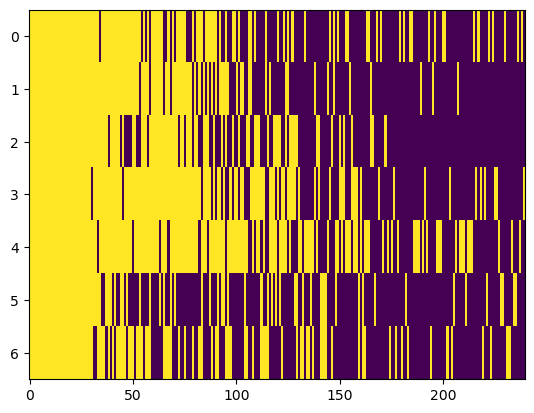

In [389]:
idx_red = track.check_red_cell_consistency(idx_ses=idx_ses, keepPlanes=None, use_s2p=True)
idx_has_red = idx_red[:, np.any(idx_red, axis=0)]
idx_sort = np.argsort(-np.sum(idx_has_red,axis=0))
idx_plot = idx_has_red[:, idx_sort]
plt.close('all')
plt.imshow(idx_plot, aspect='auto', interpolation='none')
plt.show()

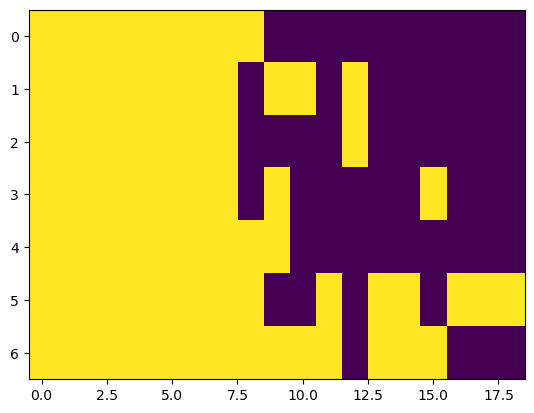

In [392]:
idx_red = track.check_red_cell_consistency(idx_ses=idx_ses, keepPlanes=None)
idx_has_red = idx_red[:, np.sum(idx_red, axis=0)>0]
idx_sort = np.argsort(-np.sum(idx_has_red,axis=0))
idx_plot = idx_has_red[:, idx_sort]
plt.close('all')
plt.imshow(idx_plot, aspect='auto', interpolation='none')
plt.show()

In [ ]:
# next step in analysis: 
# Also - using a cutoff point by the hitch in that distribution might ignore true matches that are soma-dendritic, but maybe I can use ROICaT or npix to avoid those? 

In [ ]:
# okay, looking at these clusters, it seems like there is some serious oversplitting going on in suite2p. That sucks!
# I think I should probably try to rerun some suite2p sessions....
# But for now I'll probably do a "merge" procedure... and I honestly think I'll have to overwrite or add a new "modified" suite2p folder with the stat and ops files